# **6.** Load Reported Pressure-Broadening Data from Literature
***

## Table of Contents
* [**6.1** | Load the broadening coefficients collected from the literature](#6.1---Load-literature-data-from-Excel)
    * Excel spreadsheet $\rightarrow$ DataFrame
* [**6.2** | Explore and visulize them](#6.2.---Exploratory-data-analysis-on-the-broadening-data)
    * [**6.2.1** | Explore J quantum number](#6.2.1---Explore-J$_{low}$-values)
    * [**6.2.2** | Filtering through different conditions: choose authors, choose symmetry, uncertainty threshold, etc.](#6.2.2---Filter-the-data)
    * [**6.2.3** | Visualize the data interactively - J quantum number, pressure proadening coefficient $\gamma_{L}$, collisional broadening coefficient n$_{\gamma}$](#6.2.3---Visualize-the-data)
* [**6.3** | Fit the Data using a 4th Pade equation to interpolate/extrapolate them](#6.3---Fit-$\gamma_{L}$-and-n$_{T}$-versus-J$_{low}$-using-4th-Pade)
    * Fit $\gamma_{L}$ and n$_{\gamma}$ to J$_{low}$ in a chosen range
    * Calculate fitting metrics - MSE, RMSE, $R^{2}$, 1$\sigma$ confidence 
* [**6.4** | Create, plot, and save the results](#6.4---Create,-plot,-and-save-the-results)
    * [**6.4.1** | Create all coefficients](#6.4.1---Create-coefficients)
    * [**6.4.2** | Check the results, save plots](#6.4.2---Plot-all-fitted-data)
    * [**6.4.3** | Save the coefficients into a CSV file](#6.4.3---Save-the-coefficients)

In [23]:
# Import module
from Xpectra.FitLiteratureData import *

In [2]:
# Call environment variable and assign path to data
__reference_data_path__ = os.getenv("Xpectra_reference_data")

# Define file path
sheet_name = 'pressure_broadening_ch4_forEmily_v2.xlsx'

## **6.1** - Load literature data from Excel 

$\rightarrow$ Initialize class: FitLiteratureData

In [3]:
# Create instance using environment variable
fit_lit = FitLiteratureData(__reference_data__ = __reference_data_path__)

$\rightarrow$ Load literature data from excel spreadsheet into DataFrame, using the name of the spreadsheet (e.g. "name.xlsx"). Verify the literature spreadsheet is in your *Xpectra_project / reference_data / datasets* directory 

In [4]:
# Convert file to DataFrame
fit_lit.pb_excel_reader(sheet_name = sheet_name)

In [22]:
# Updated instance attribute: literature_df 
fit_lit.literature_df.head() # Display header and first 5 columns

author    year absorber perturber band Branch  J_up C_up  N_up  \
0  Gharib-Nezhad  2019.0      CH4        H2   v3      P   1.0   F1   7.0   
1  Gharib-Nezhad  2019.0      CH4        H2   v3      P   1.0    E   4.0   
2  Gharib-Nezhad  2019.0      CH4        H2   v3      P   2.0   F1   8.0   
3  Gharib-Nezhad  2019.0      CH4        H2   v3      P   2.0   A1   4.0   
4  Gharib-Nezhad  2019.0      CH4        H2   v3      P   2.0   F1   9.0   

   J_low C_low  N_low     WN[cm-1]  gamma_L [cm-1/atm]  gamma_uncertainty  \
0    2.0    F2    1.0  2998.994032               0.068            0.00100   
1    2.0     E    1.0  2999.060420               0.069            0.00345   
2    3.0    F2    1.0  2987.215699               0.068            0.34000   
3    3.0    A2    1.0  2988.795216               0.066            0.00100   
4    3.0    F2    1.0  2988.932545               0.068            0.00100   

   n_gamma  n_uncertainty  
0     0.72           0.04  
1     0.65           0.04  
2     0.66           0.00  
3     0.60           0.03  
4     0.63           0.04

## **6.2.** - Exploratory data analysis on the broadening data

In [6]:
# Show non-null values for each column
fit_lit.literature_df.count()

author                490
year                  444
absorber              444
perturber             444
band                  444
Branch                444
J_up                  187
C_up                  187
N_up                  187
J_low                 490
C_low                 488
N_low                 253
WN[cm-1]              444
gamma_L [cm-1/atm]    470
gamma_uncertainty     470
n_gamma               163
n_uncertainty         163
dtype: int64

In [7]:
# Show counts from each author
fit_lit.literature_df['author'].value_counts()

author
Yousefi          191
Gharib-Nezhad    143
Pine              66
fake              46
Es-sebbar         44
Name: count, dtype: int64

- Note: there are 46 fake data points for fitting purposes

### **6.2.1** - Explore J$_{low}$ values

$\rightarrow$ Let's look at the available J$_{low}$ data points from the literature, first choosing only real authors:

In [8]:
# Get list of real authors
df_authors = fit_lit.literature_df['author'].dropna().unique()
real_author_list = list(np.delete(df_authors, np.where(df_authors=='fake')))

real_author_list

['Gharib-Nezhad', 'Es-sebbar', 'Pine', 'Yousefi ']

$\rightarrow$ A histogram can best represent the distribution between the authors:

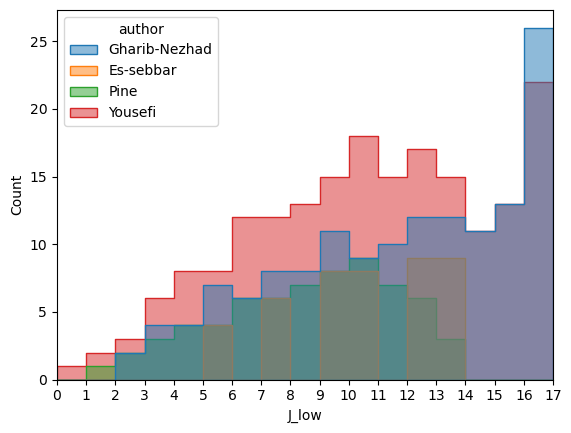

In [9]:
filters = {'author': real_author_list}

fit_lit.plot_literature_hist(hist_param = 'J_low',
                             hist_param_range=[0,17],
                             sort_by = 'author',
                             filters = filters,
                             bins = 17,
                             dpi=100
                            )

### **6.2.2** - Filter the data

$\rightarrow$ As a part of exploratory data analysis, we want to look at different sub-sections of the data. Let's look at the manually inserted, or "fake", data points 

$\rightarrow$ Without these points, the fitted 4th order equation would predict the data over the wider J range in an unphysical way. 

In [10]:
# Filter to only fake data 
filters = {'author':['fake']}

# Return DataFrame with only fake data points
df_fake_author = FitLiteratureData.filter_dataframe(fit_lit.literature_df, filters=filters)

# Display headers and first 5 columns
df_fake_author.head()

author  year absorber perturber band Branch  J_up C_up  N_up  J_low C_low  \
448   fake   NaN      NaN       NaN  NaN    NaN   NaN  NaN   NaN    0.0    A1   
449   fake   NaN      NaN       NaN  NaN    NaN   NaN  NaN   NaN    1.0    A1   
450   fake   NaN      NaN       NaN  NaN    NaN   NaN  NaN   NaN    4.0    A1   
451   fake   NaN      NaN       NaN  NaN    NaN   NaN  NaN   NaN   50.0    A1   
452   fake   NaN      NaN       NaN  NaN    NaN   NaN  NaN   NaN  100.0    A1   

     N_low  WN[cm-1]  gamma_L [cm-1/atm]  gamma_uncertainty  n_gamma  \
448    NaN       NaN               0.070              0.002      NaN   
449    NaN       NaN               0.070              0.002      NaN   
450    NaN       NaN               0.070              0.002      NaN   
451    NaN       NaN               0.005              0.003      NaN   
452    NaN       NaN               0.005              0.002      NaN   

     n_uncertainty  
448            NaN  
449            NaN  
450            NaN  
451            NaN  
452            NaN

### **6.2.3** - Visualize the data

$\rightarrow$ Creating a filter dictionary for visualization purposes, filter any column by chosen values or filter by a condition

In [11]:
filters = {
    'gamma_uncertainty': lambda x: x < 0.05,
    #'C_low' : ['E'],
    #'absorber': ['CH4'], 
    'author': ['Yousefi ', 'Gharib-Nezhad', 'Pine', 'Es-sebbar'] # real authors
}   

$\rightarrow$ We plot pressure broadening $\gamma_{L}$ versus J lower quantum number J$_{low}$

$\rightarrow$ Can choose category to label and color-code the data with interactive legend. Default is 'author'

In [12]:
fit_lit.plot_with_uncertainty(param_to_sort='author', # C_low, author
                              filters=filters)

## **6.3** - Fit $\gamma_{L}$ and n$_{T}$ versus J$_{low}$ using 4th Pade

$\rightarrow$ Fit a curve to the data using the 4th Pade equation

$\rightarrow$ The function plots the fitted curve, prints the fitted parameters, and returns them in an array

In [13]:
# Choose new filters
filters = {
    'gamma_uncertainty': lambda x: x < 0.01, # Maximum uncertainty threshold
    'C_low' : ['A1','A2','E','F1','F2'], 
    'author' : ['Gharib-Nezhad','fake'] # Filter to only Gharib-Nezhad and fake data points
}  

# Plot J_low vs gamma_L with uncertainty, fitting 4th pade
fit_lit.plot_with_uncertainty(param_to_sort = 'C_low', # Color-code by symmetry
                              filters = filters, 
                              fit_4thPade = True,
                              show_plot = True
                             )

a0: 0.07 +/- 0.003
a1: -713.724 +/- 67744643.277
a2: 35.902 +/- 3407708.755
a3: -0.561 +/- 53214.811
b1: -10310.6 +/- 978654247.181
b2: 437.164 +/- 41494658.868
b3: -3.726 +/- 353718.362
b4: -0.541 +/- 51325.137


array([ 6.97999340e-02, -7.13723787e+02,  3.59018004e+01, -5.60642616e-01,
       -1.03106001e+04,  4.37164119e+02, -3.72644120e+00, -5.40736411e-01])

In [14]:
# Choose filters
filters = {
    'n_uncertainty': lambda x: x < 0.2, # Maximum uncertainty threshold
    'C_low' : ['A1','A2','E','F1','F2'],
}   

# Plot J_low vs n_gamma
fit_lit.plot_with_uncertainty(param_to_sort='author', # Color-code by author
                              param_to_fit = 'n_gamma',
                              param_to_fit_uncertainty = 'n_uncertainty',
                              filters = filters,
                              fit_4thPade = True,
                              show_plot = True,
                              )

a0: 0.591 +/- 0.088
a1: -0.117 +/- 0.077
a2: 0.005 +/- 0.013
a3: 0.0 +/- 0.001
b1: -0.244 +/- 0.099
b2: 0.023 +/- 0.017
b3: -0.001 +/- 0.002
b4: 0.0 +/- 0.0


array([ 5.91162266e-01, -1.16793973e-01,  4.69417444e-03,  1.09808182e-04,
       -2.43905518e-01,  2.30231991e-02, -1.44995374e-03,  5.90924551e-05])

## **6.4** - Create, plot, and save the results

$\rightarrow$ To save these fitted pressure broadening coefficients, we need to account for each symmetry, fitting an equation to n_gamma and gamma_L within each and assigning sets of coefficients to arrays. 

In [15]:
# All C_low symmetry values
sym_pbro = ['A1','A2','E','F1','F2']

### **6.4.1** - Create coefficients

In [16]:
for sym in sym_pbro: # For each symmetry:
    
    # Set nT filters
    filters_nT = {
    'n_uncertainty': lambda x: x > 0.001,
    'n_gamma': lambda x: x < 1,
    'C_low': [sym]}
    # Assign n_T_H2_(symmetry) array to corrsponding fitted pbro coefficients 
    globals()[f'n_T_H2_{sym}'] =  fit_lit.plot_with_uncertainty(param_to_fit='n_gamma',
                                                                param_to_fit_uncertainty='n_uncertainty',
                                                                x_fit=[0,100],
                                                                include_authors=['Gharib-Nezhad','fake','Es-sebbar'],
                                                                filters=filters_nT,
                                                                fit_4thPade=True,
                                                                print_fitted_params=False,
                                                                show_plot=False)  
    
    # Set gamma filters
    filters_gamma = {
        'gamma_uncertainty': lambda x: x < 0.01,
        'C_low': [sym]}   
    # Assign gamma_L_H2_(symmetry) array to corrsponding fitted pbro coefficients
    globals()[f'gamma_L_H2_{sym}'] =  fit_lit.plot_with_uncertainty(x_fit=[0,100],
                                                                    include_authors=['Gharib-Nezhad','fake','Es-sebbar'],
                                                                    filters=filters_gamma,
                                                                    fit_4thPade=True,
                                                                    print_fitted_params=False,
                                                                    show_plot=False)
    

$\rightarrow$ Load arrays of fitted coefficients into a DataFrame

In [17]:
# Create DataFrame to save fitted coefficients
df_pbro = pd.DataFrame(columns=('coeff','abs','bro','sym_low', 
                                'a0','a1','a2','a3','b1','b2','b3','b4'))

# Load gamma_L 4th pade coefficients into dataframe
fitted_pbro_gamma = [gamma_L_H2_F1, gamma_L_H2_F2, gamma_L_H2_E, gamma_L_H2_A1, gamma_L_H2_A2]
i=0
for pbro_data, sym in zip(fitted_pbro_gamma, sym_pbro):
    df_pbro.loc[i,'a0':'b4'] =  pbro_data
    df_pbro.loc[i,'sym_low'] = sym
    df_pbro.loc[i,'coeff'] = 'gamma_L'
    df_pbro.loc[i,'abs'] = 'CH4'
    df_pbro.loc[i,'bro'] = 'H2'
    i += 1

# Load n_T 4th pade coefficients into dataframe
fitted_pbro_n = [n_T_H2_F1, n_T_H2_F2, n_T_H2_E, n_T_H2_A1, n_T_H2_A2]  
for pbro_data, sym in zip(fitted_pbro_n, sym_pbro):
    df_pbro.loc[i,'a0':'b4'] =  pbro_data
    df_pbro.loc[i,'sym_low'] = sym
    df_pbro.loc[i,'coeff'] = 'n_T'
    df_pbro.loc[i,'abs'] = 'CH4'
    df_pbro.loc[i,'bro'] = 'H2'  
    i += 1

In [18]:
# Show the results
display(df_pbro)

coeff  abs bro sym_low        a0            a1           a2          a3  \
0  gamma_L  CH4  H2      A1      0.07 -28739.842754  1527.618755  -27.399937   
1  gamma_L  CH4  H2      A2      0.07  -1131.894063    53.781878   -0.809802   
2  gamma_L  CH4  H2       E      0.07   -263.072769    22.271939   -0.683776   
3  gamma_L  CH4  H2      F1   0.06961     -0.073627     0.004083   -0.000067   
4  gamma_L  CH4  H2      F2  0.068634     -0.023844     0.000785   -0.000008   
5      n_T  CH4  H2      A1   0.76997     122.59176   -23.715542    2.410308   
6      n_T  CH4  H2      A2  0.769999   1785.193329  -941.443828  123.274112   
7      n_T  CH4  H2       E  0.699775     45.847077     -4.21069    0.128119   
8      n_T  CH4  H2      F1  0.520414     -0.114582     0.008924   -0.000291   
9      n_T  CH4  H2      F2  0.570681     -0.195296     0.011027    0.000778   

              b1           b2          b3        b4  
0 -418580.145555  20089.24665 -104.443746 -32.87042  
1  -16484.751276   794.607473  -18.403874 -0.626174  
2   -3470.478648    94.003676    17.31892 -1.265039  
3      -1.034819     0.033477    0.001413 -0.000087  
4      -0.350065      0.01353   -0.000435 -0.000002  
5     159.244294   -15.774117   -0.647397  0.283237  
6    2191.586313 -1038.009986   94.392414  6.840596  
7      66.870841    -4.984585    0.060632  0.010067  
8      -0.213284     0.011817    0.000285 -0.000037  
9      -0.384443     0.041386   -0.002145  0.000173

### **6.4.2** - Plot all fitted data

$\rightarrow$ As a verification, let's calculate gamma_L and n_T using these coeffients, and visualize interactively (with Bokeh):

In [19]:
fit_lit.plot_fitted_value_bokeh(df_pbro,
                        y_param = 'gamma_L',
                        J_range = [0,150])

fit_lit.plot_fitted_value_bokeh(df_pbro,
                        y_param = 'n_T',
                        J_range = [0,150])

$\rightarrow$ Save the plots (with Seaborn):

In [20]:
fit_lit.plot_fitted_value_seaborn(df_pbro,
                                  y_param = 'gamma_L',
                                  J_range = [0,150],
                                  __save_plot__ = True,
                                  __show_plot__ = False)

fit_lit.plot_fitted_value_seaborn(df_pbro,
                                  y_param = 'n_T',
                                  J_range = [0,150],
                                  __save_plot__ = True,
                                  __show_plot__ = False)

<Figure size 640x480 with 0 Axes>

### **6.4.3** - Save the coefficients

In [21]:
# Define file path
save_path = os.path.join(__reference_data_path__,'outputs','ch4_Pbroadening_4thPade.csv')

# Save df as CSV
df_pbro.to_csv(save_path,index=False, columns=df_pbro.columns)